In [2]:
import numpy as np
import pandas as pd
from scipy.stats import binom
from scipy.stats import uniform
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm

SystemError: initialization of _internal failed without raising an exception

In [2]:
pip install pymc3

  Using cached pymc3-3.11.5-py3-none-any.whl (872 kB)
  Using cached fastprogress-1.0.3-py3-none-any.whl (12 kB)
  Using cached Theano_PyMC-1.1.2-py3-none-any.whl
  Using cached deprecat-2.1.1-py2.py3-none-any.whl (9.8 kB)
Note: you may need to restart the kernel to use updated packages.


## Webpage

In [ ]:
df=pd.read_csv('ab_testing.csv')
df


In [3]:
df[['group','landing_page']].value_counts()

NameError: name 'df' is not defined

In [5]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Consideramos Beta(2,8) para la distribucion previa

<AxesSubplot:ylabel='Density'>

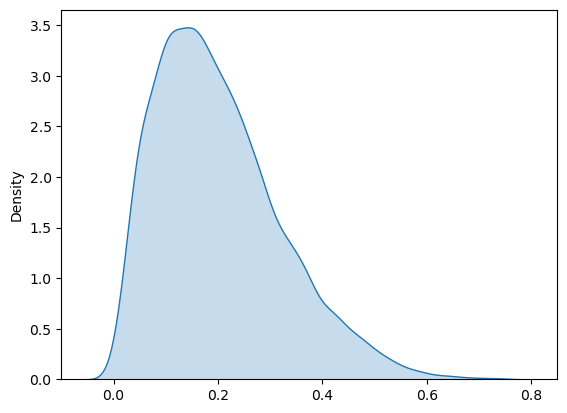

In [6]:
prior_draws = np.random.beta(2,8,10000)
# Plot density of posterior_draws
sns.kdeplot(prior_draws, shade=True)

In [7]:
old_page = df.loc[df["landing_page"] == "old_page"]["converted"]
new_page = df.loc[df["landing_page"] == "new_page"]["converted"]

In [8]:
def simulate_beta_posterior(trials, beta_prior_a, beta_prior_b):
    num_successes = np.sum(trials)
    num_failures= len(trials) - num_successes
    posterior_draws = np.random.beta(num_successes + beta_prior_a,  num_failures + beta_prior_b,10000)
    return posterior_draws

In [9]:
oldpage_posterior = simulate_beta_posterior(old_page,2, 8)

newpage_posterior = simulate_beta_posterior(new_page, 2, 8)

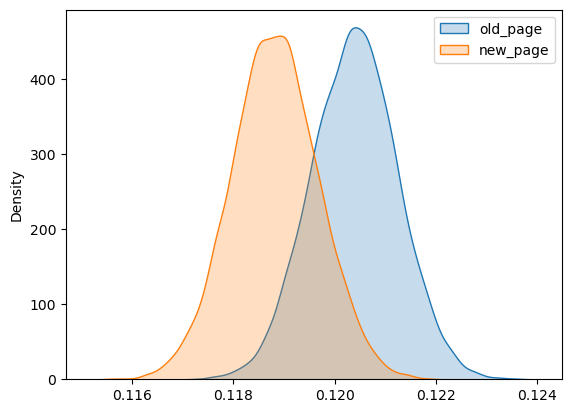

In [10]:
sns.kdeplot(oldpage_posterior, shade=True, label="old_page")
sns.kdeplot(newpage_posterior, shade=True, label="new_page")
plt.legend()
plt.show()

Las densidades posterior muestran que antigua página está un poco mejor. Sin embargo las densidades son superpuestas. Por lo tanto es probable que la nueva página sea mejor. Qué tan probable es que la pagina antigua sea mejor? 

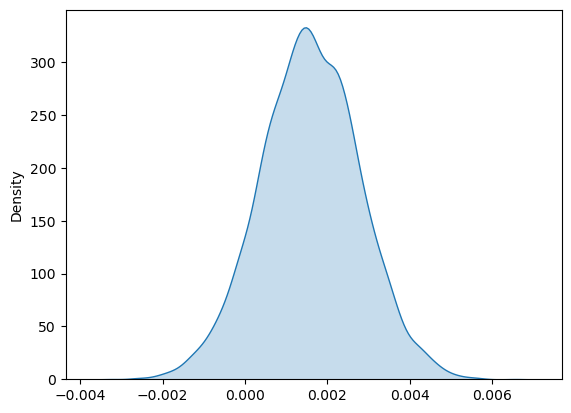

[-0.00036702  0.00357405]
0.9036


In [11]:
# Calcular la diferencia entre las posteriores
diff = oldpage_posterior - newpage_posterior
sns.kdeplot(diff, shade=True, label="diff")
plt.show()

# Calcular HDI 90% 
interval = az.hdi(diff, hdi_prob=0.9)
print(interval)

# Calcular la probabilidad que la pagina antigua sea mejor 
oldpage_better_prob = (diff>0).mean()
print(oldpage_better_prob)

In [19]:
print(diff>0)
#print(diff[diff<0])

[ True  True  True ...  True  True  True]


array([False, False, False, ..., False, False, False])

La diferencia de las densidades posterior (oldpage_posterior - newpage_posterior) es mayoriamente positiva, lo que indica que es más probable que la antigua página sea mejor, pero no con una alta probabilidad. El intervalo de credibilidad (hdi) indica que con un 90% de probabilidad, la tasa de suscripción de la antigua página es hasta un 0.35% superior a la de la nueva página. 

La probabilidad de que la tasa de suscripción de la antigua página sea mayor es 90%. Sin embargo, existe un 10% de probabilidad de que la nueva página sea realmente mejor.

In [15]:
# Slice diff to take only cases where it is negative (corresponding to newpage subscription being higher) 
loss = diff[diff<0]

# Compute and print expected loss
expected_loss = loss.mean()
print(expected_loss)

-0.0005698365741680541


Si implementamos la antigua página y la nueva página resulta ser mejor (con una probabilidad del 10%), solo perderemos un 0.05 porcentaje en la suscripción que es un riesgo muy bajo.


array([<AxesSubplot:title={'center':'newpage_rev'}>,
       <AxesSubplot:title={'center':'oldpage_rev'}>], dtype=object)

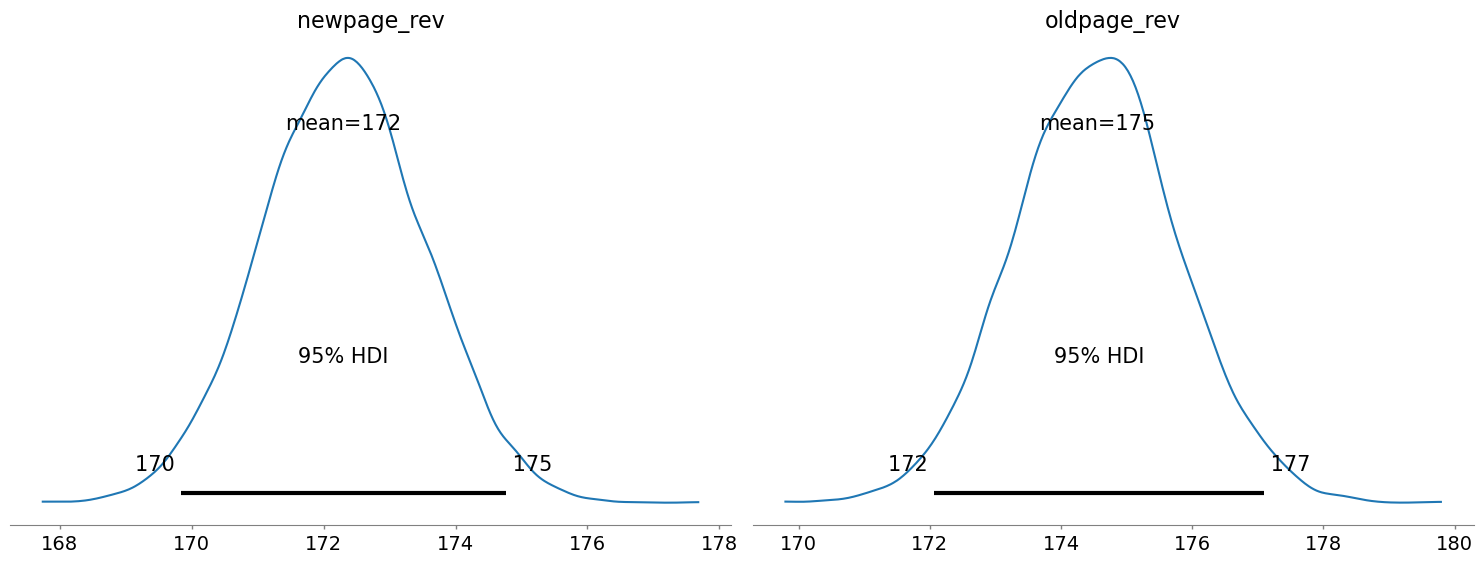

In [22]:
az.plot_posterior(revs, hdi_prob=0.95, multimodal=True)

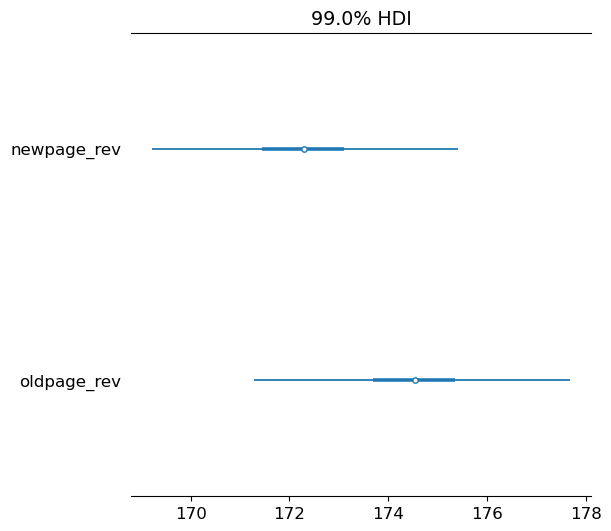

In [24]:
newpage_num_clicks = newpage_posterior * 145
oldpage_num_clicks = oldpage_posterior * 145


revs = {"newpage_rev": newpage_num_clicks * 10,
        "oldpage_rev": oldpage_num_clicks * 10}


pm.plot_forest(revs, hdi_prob=0.99, textsize=12)

plt.show()

In [21]:
0.6/0.2

2.9999999999999996

In [22]:
3/4

0.75